# 환경/로드

In [2]:
# --- 기본 imports ---
import os
import numpy as np
import pandas as pd

# 시각화 (노트북용)
import matplotlib.pyplot as plt

# (선택) plotly로도 보고 싶으면
import plotly.express as px


pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Ready")


Ready


In [10]:
import os
import json
import pandas as pd
import streamlit as st



def load_csv(path: str):
    """CSV 전체 로드 (샘플링 없음)"""
    return pd.read_csv(path)



def load_tsv(path: str):
    """TSV 파일 로딩"""
    return pd.read_csv(path, sep="\t")



def load_json(path: str):
    """JSON 파일 로딩"""
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None


def load_all_data(base_path: str):
    """
    base_path 아래 데이터셋을 모두 로드해서 dict로 반환.
    모든 데이터 FULL LOAD (샘플링 없음)
    """
    data = {}

    # ratings (FULL LOAD)
    ratings_path = os.path.join(base_path, "train_ratings.csv")
    data["ratings"] = load_csv(ratings_path)

    # tsv들
    data["titles"] = load_tsv(os.path.join(base_path, "titles.tsv"))
    data["years"] = load_tsv(os.path.join(base_path, "years.tsv"))
    data["genres"] = load_tsv(os.path.join(base_path, "genres.tsv"))
    data["directors"] = load_tsv(os.path.join(base_path, "directors.tsv"))
    data["writers"] = load_tsv(os.path.join(base_path, "writers.tsv"))

    # JSON mapping
    json_path = os.path.join(base_path, "Ml_item2attributes.json")
    data["item2attributes"] = load_json(json_path)

    return data

    


In [11]:
# --- 데이터 경로 설정 ---
# 방법1: 환경변수로 받기 (추천)
# DATA_PATH = os.environ.get("DATA_PATH", None)

# 방법2: 직접 넣기
DATA_PATH = "/data/ephemeral/home/data/raw/train"

# assert DATA_PATH is not None, "DATA_PATH를 환경변수로 넣거나 위에서 직접 지정해줘!"

data = load_all_data(DATA_PATH)
ratings = data["ratings"].copy()

ratings["datetime"] = pd.to_datetime(ratings["time"], unit="s")
ratings.head(), ratings.shape


(   user  item        time            datetime
 0    11  4643  1230782529 2009-01-01 04:02:09
 1    11   170  1230782534 2009-01-01 04:02:14
 2    11   531  1230782539 2009-01-01 04:02:19
 3    11   616  1230782542 2009-01-01 04:02:22
 4    11  2140  1230782563 2009-01-01 04:02:43,
 (5154471, 4))

# 

# Movie_df 만들기 
- ['item', 'review_count', 'genre', 'year', 'director', 'writer', 'title']

In [45]:
# item 전체 목록 기준 base_df
all_items = pd.DataFrame({"item": movie_df["item"]}) if "movie_df" in globals() \
            else pd.DataFrame({"item": ratings["item"].unique()})

# 1) 장르 개수
genre_count_per_item = data["genres"].groupby("item")["genre"].count().rename("n_genres")

# 2) 감독 수
director_count_per_item = data["directors"].groupby("item")["director"].count().rename("n_directors")

# 3) 작가 수
writer_count_per_item = data["writers"].groupby("item")["writer"].count().rename("n_writers")

# 4) 연도 수
year_count_per_item = data["years"].groupby("item")["year"].count().rename("n_years")

# 5) 제목 수
title_count_per_item = data["titles"].groupby("item")["title"].count().rename("n_titles")

# -------- merge to include missing items ----------
feature_count_df = all_items.merge(genre_count_per_item, on="item", how="left")
feature_count_df = feature_count_df.merge(director_count_per_item, on="item", how="left")
feature_count_df = feature_count_df.merge(writer_count_per_item, on="item", how="left")
feature_count_df = feature_count_df.merge(year_count_per_item, on="item", how="left")
feature_count_df = feature_count_df.merge(title_count_per_item, on="item", how="left")

print("📌 아이템별 feature multiplicity")
display(feature_count_df.head())

print("\n📌 Feature count summary (분포)")
display(feature_count_df.describe())

# -------------------------------
# 🔥 추가: feature별 결측치 비율
# -------------------------------
null_ratio = feature_count_df.isna().mean().rename("null_ratio")

print("\n📌 Feature별 결측치 비율")
display(null_ratio)


📌 아이템별 feature multiplicity


,item,n_genres,n_directors,n_writers,n_years,n_titles
0,1,5,1.0,7.0,1.0,1
1,2,3,1.0,3.0,1.0,1
2,3,2,1.0,1.0,1.0,1
3,4,3,1.0,1.0,1.0,1
4,5,1,1.0,4.0,1.0,1



📌 Feature count summary (분포)


,item,n_genres,n_directors,n_writers,n_years,n_titles
count,6807.000000,6807.000000,5503.000000,5648.000000,6799.0,6807.0
mean,26626.948142,2.340679,1.073051,2.001771,1.0,1.0
std,32194.062445,1.114049,0.420017,1.546859,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,3054.500000,1.000000,1.000000,1.000000,1.0,1.0
50%,6882.000000,2.000000,1.000000,2.000000,1.0,1.0
75%,49823.000000,3.000000,1.000000,2.000000,1.0,1.0
max,119145.000000,10.000000,14.000000,24.000000,1.0,1.0



📌 Feature별 결측치 비율


item           0.000000
n_genres       0.000000
n_directors    0.191568
n_writers      0.170266
n_years        0.001175
n_titles       0.000000
Name: null_ratio, dtype: float64

In [46]:
# 리스트로 묶기 (one-to-many 해결)
genres_per_item = data["genres"].groupby("item")["genre"].apply(list).rename("genres")
directors_per_item = data["directors"].groupby("item")["director"].apply(list).rename("directors")
writers_per_item = data["writers"].groupby("item")["writer"].apply(list).rename("writers")

# 대표값을 사용 (year/title은 보통 1개)
year_per_item = data["years"].groupby("item")["year"].first().rename("year")
title_per_item = data["titles"].groupby("item")["title"].first().rename("title")

item_review_count = ratings.groupby("item")["user"].count().rename("review_count")

movie_df = pd.DataFrame({"item": item_review_count.index})
movie_df["review_count"] = item_review_count.values

movie_df = movie_df.merge(genres_per_item, on="item", how="left")
movie_df = movie_df.merge(year_per_item, on="item", how="left")
movie_df = movie_df.merge(directors_per_item, on="item", how="left")
movie_df = movie_df.merge(writers_per_item, on="item", how="left")
movie_df = movie_df.merge(title_per_item, on="item", how="left")

ratings["datetime"] = pd.to_datetime(ratings["time"], unit="s")

item_first_dt = ratings.groupby("item")["datetime"].min().rename("first_datetime")
item_last_dt  = ratings.groupby("item")["datetime"].max().rename("last_datetime")

movie_df = movie_df.merge(item_first_dt, on="item", how="left")
movie_df = movie_df.merge(item_last_dt, on="item", how="left")

movie_df["activity_span"] = movie_df["last_datetime"] - movie_df["first_datetime"]

print("📌 movie_df — item당 1행이 보장됨")
display(movie_df.head())



📌 movie_df — item당 1행이 보장됨


,item,review_count,genres,year,directors,writers,title,first_datetime,last_datetime,activity_span
0,1,12217,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,[nm0005124],"[nm0004056, nm0005124, nm0169505, nm0230032, n...",Toy Story (1995),2005-04-11 12:41:27,2015-03-30 19:57:57,3640 days 07:16:30
1,2,3364,"[Adventure, Children, Fantasy]",1995.0,[nm0002653],"[nm0378144, nm0852430, nm0885575]",Jumanji (1995),2005-04-13 07:34:58,2015-03-30 12:31:07,3638 days 04:56:09
2,3,734,"[Comedy, Romance]",1995.0,[nm0222043],[nm0425756],Grumpier Old Men (1995),2005-04-11 17:55:49,2015-03-26 18:25:06,3636 days 00:29:17
3,4,43,"[Comedy, Drama, Romance]",1995.0,[nm0001845],[nm0060103],Waiting to Exhale (1995),2005-05-09 10:54:42,2015-03-22 21:45:09,3604 days 10:50:27
4,5,590,[Comedy],1995.0,[nm0796124],"[nm0329304, nm0352443, nm0583600, nm0796124]",Father of the Bride Part II (1995),2005-04-13 16:16:13,2015-03-22 21:52:02,3630 days 05:35:49


In [47]:
# 유저별 activity 정보 필요
user_activity_count = ratings.groupby("user")["item"].count()
user_first = ratings.groupby("user")["datetime"].min()
user_last = ratings.groupby("user")["datetime"].max()
user_lifetime = (user_last - user_first).dt.days

# item별 user list
item_users = ratings.groupby("item")["user"].apply(list)

# 요약 feature 생성 함수
def summarize_users(user_list):
    users = pd.Series(user_list)

    return pd.Series({
        "item_user_median_activity": user_activity_count.loc[users].median(),
        "item_user_heavy_ratio": (user_activity_count.loc[users] > user_activity_count.quantile(0.9)).mean()
    })

item_user_summary = item_users.apply(summarize_users)
movie_df = movie_df.merge(item_user_summary, on="item", how="left")



In [48]:
movie_df.columns
print(len(movie_df))
movie_df.info()


6807
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   item                       6807 non-null   int64          
 1   review_count               6807 non-null   int64          
 2   genres                     6807 non-null   object         
 3   year                       6799 non-null   float64        
 4   directors                  5503 non-null   object         
 5   writers                    5648 non-null   object         
 6   title                      6807 non-null   object         
 7   first_datetime             6807 non-null   datetime64[ns] 
 8   last_datetime              6807 non-null   datetime64[ns] 
 9   activity_span              6807 non-null   timedelta64[ns]
 10  item_user_median_activity  6807 non-null   float64        
 11  item_user_heavy_ratio      6807 non-null   float64 

In [57]:
def safe_len(x):
    if isinstance(x, list):
        return len(x)
    return 0


feature_len_df = movie_df[[
    "item", "directors", "writers", "genres"
]].copy()

feature_len_df["n_directors"] = feature_len_df["directors"].apply(safe_len)
feature_len_df["n_writers"]   = feature_len_df["writers"].apply(safe_len)
feature_len_df["n_genres"]    = feature_len_df["genres"].apply(safe_len)

feature_len_df.head()


,item,directors,writers,genres,n_directors,n_writers,n_genres
0,1,[nm0005124],"[nm0004056, nm0005124, nm0169505, nm0230032, n...","[Adventure, Animation, Children, Comedy, Fantasy]",1,7,5
1,2,[nm0002653],"[nm0378144, nm0852430, nm0885575]","[Adventure, Children, Fantasy]",1,3,3
2,3,[nm0222043],[nm0425756],"[Comedy, Romance]",1,1,2
3,4,[nm0001845],[nm0060103],"[Comedy, Drama, Romance]",1,1,3
4,5,[nm0796124],"[nm0329304, nm0352443, nm0583600, nm0796124]",[Comedy],1,4,1


In [58]:
feature_len_df[["n_directors", "n_writers", "n_genres"]].describe()


,n_directors,n_writers,n_genres
count,6807.000000,6807.000000,6807.000000
mean,0.867489,1.660937,2.340679
std,0.566536,1.597339,1.114049
min,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,1.000000,2.000000,3.000000
max,14.000000,24.000000,10.000000


In [59]:
movie_df["n_writers"] = movie_df["writers"].apply(lambda x: len(x) if isinstance(x, list) else 0)
movie_df["n_genres"]  = movie_df["genres"].apply(lambda x: len(x) if isinstance(x, list) else 0)


## 장르 조합 별 item 갯수

### 1️⃣ 장르 조합 만들기 (핵심)

In [61]:
# 장르 조합 컬럼 생성
movie_df["genre_combo"] = movie_df["genres"].apply(
    lambda x: tuple(sorted(x)) if isinstance(x, list) and len(x) > 0 else ("UNKNOWN",)
)

movie_df[["genres", "genre_combo"]].head()


,genres,genre_combo
0,"[Adventure, Animation, Children, Comedy, Fantasy]","(Adventure, Animation, Children, Comedy, Fantasy)"
1,"[Adventure, Children, Fantasy]","(Adventure, Children, Fantasy)"
2,"[Comedy, Romance]","(Comedy, Romance)"
3,"[Comedy, Drama, Romance]","(Comedy, Drama, Romance)"
4,[Comedy],"(Comedy,)"


### 2️⃣ 장르 조합별 아이템 개수 & review_count 집계

In [62]:
genre_combo_stats = (
    movie_df
    .groupby("genre_combo")
    .agg(
        n_items=("item", "count"),
        total_review_count=("review_count", "sum"),
        mean_review_count=("review_count", "mean"),
        median_review_count=("review_count", "median"),
    )
    .reset_index()
)


In [63]:
genre_combo_stats.sort_values(
    "n_items", ascending=False
).head(10)


,genre_combo,n_items,total_review_count,mean_review_count,median_review_count
633,"(Drama,)",832,368934,443.430288,132.5
478,"(Comedy,)",464,238351,513.687500,164.0
507,"(Comedy, Drama)",308,154547,501.775974,169.5
689,"(Drama, Romance)",297,154055,518.703704,174.0
566,"(Comedy, Romance)",246,147546,599.780488,183.0
625,"(Documentary,)",229,62353,272.283843,134.0
526,"(Comedy, Drama, Romance)",228,157176,689.368421,209.5
700,"(Drama, Thriller)",132,74464,564.121212,220.0
580,"(Crime, Drama)",107,170083,1589.560748,367.0
601,"(Crime, Drama, Thriller)",100,82272,822.720000,258.0


### 5️⃣ “희귀하지만 리뷰 많은” 장르 조합 찾기 (꿀 인사이트)
👉 이런 조합들:

- 제작은 드물지만

- 나오면 확실히 먹히는 장르 조합

→ 추천 시스템에서 발견형 추천(discovery) 에 매우 좋음.

In [70]:
# 아이템 수는 적은데, 평균 리뷰는 높은 조합
rare_but_popular = genre_combo_stats.query(
    "n_items <= 10"
).sort_values(
    "mean_review_count", ascending=False
)

rare_but_popular.head()


,genre_combo,n_items,total_review_count,mean_review_count,median_review_count
181,"(Action, Crime, Film-Noir, Mystery, Thriller)",1,10774,10774.0,10774.0
279,"(Adventure, Animation, Children, Romance, Sci-Fi)",1,8801,8801.0,8801.0
90,"(Action, Adventure, Horror, Sci-Fi)",1,8412,8412.0,8412.0
471,"(Children, Drama, Sci-Fi)",1,8184,8184.0,8184.0
265,"(Adventure, Animation, Children, Comedy, Music...",1,6898,6898.0,6898.0


In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud 입력용 문자열 생성
# 장르 조합을 "Drama_Romance" 같은 토큰으로 만들고
# 평균 리뷰 수만큼 가중
texts = []

for _, row in rare_but_popular.iterrows():
    genre_token = "_".join(row["genre_combo"])
    weight = int(row["mean_review_count"])  # 가중치
    texts.extend([genre_token] * weight)

text_for_wc = " ".join(texts)


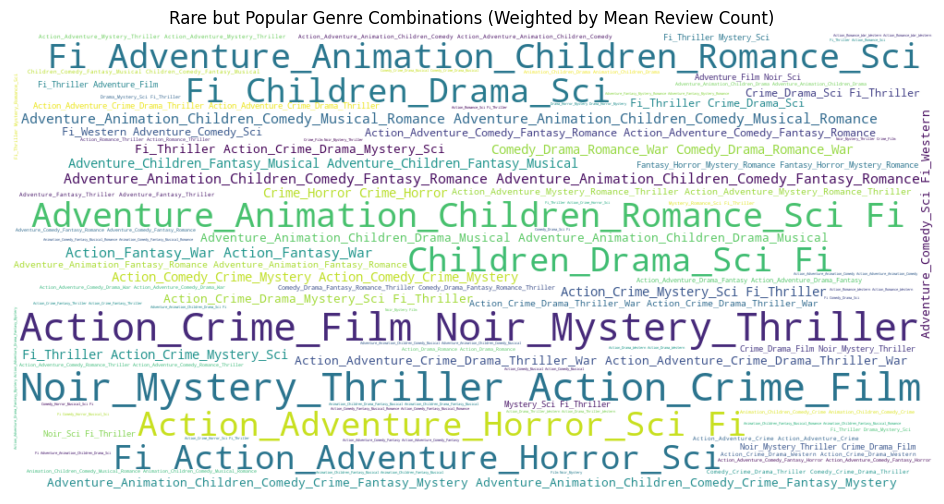

In [72]:
wc = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    colormap="viridis",
    max_words=100
)

wc.generate(text_for_wc)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Rare but Popular Genre Combinations (Weighted by Mean Review Count)")
plt.show()


In [73]:
top_combos = rare_but_popular.head(10)["genre_combo"].tolist()


In [74]:
top_combo_movies = (
    movie_df
    .assign(genre_combo=movie_df["genres"].apply(
        lambda x: tuple(sorted(x)) if isinstance(x, list) and len(x) > 0 else ("UNKNOWN",)
    ))
    .query("genre_combo in @top_combos")
    [["genre_combo", "title", "review_count"]]
    .sort_values("review_count", ascending=False)
)


In [75]:
for combo, g in top_combo_movies.groupby("genre_combo"):
    print(f"\n🎬 Genre Combo: {combo}")
    print(g[["title", "review_count"]].head(10).to_string(index=False))



🎬 Genre Combo: ('Action', 'Adventure', 'Horror', 'Sci-Fi')
        title  review_count
Aliens (1986)          8412

🎬 Genre Combo: ('Action', 'Crime', 'Film-Noir', 'Mystery', 'Thriller')
          title  review_count
Sin City (2005)         10774

🎬 Genre Combo: ('Action', 'Fantasy', 'War')
     title  review_count
300 (2007)          6677

🎬 Genre Combo: ('Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance')
                 title  review_count
          Shrek (2001)         13495
Gnomeo & Juliet (2011)            72

🎬 Genre Combo: ('Adventure', 'Animation', 'Children', 'Comedy', 'Musical', 'Romance')
         title  review_count
Shrek 2 (2004)          6898

🎬 Genre Combo: ('Adventure', 'Animation', 'Children', 'Romance', 'Sci-Fi')
        title  review_count
WALL·E (2008)          8801

🎬 Genre Combo: ('Adventure', 'Children', 'Fantasy', 'Musical')
                   title  review_count
Wizard of Oz, The (1939)          5859

🎬 Genre Combo: ('Children', 'Drama', 'S

## ratings에는 없는데 movie_df에는 있는 item 찾기 -> item_cold_start

In [49]:
all_items = set(movie_df["item"])
rated_items = set(ratings["item"])

cold_start_items = list(all_items - rated_items)

print("Cold start item count:", len(cold_start_items))


Cold start item count: 0


In [50]:
cold_items = movie_df[movie_df["review_count"] <= movie_df["review_count"].quantile(0.1)]
len(cold_items)


706

## 피쳐별 분포 -> ydata_profiling 이용

In [53]:
from ydata_profiling import ProfileReport

# movie_df 프로파일링
profile = ProfileReport(
    movie_df,
    title="Movie DF Profiling Report",
    explorative=True,
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    }
)

profile.to_file("movie_df_profile.html")
print("📄 movie_df_profile.html 생성 완료!")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00, 11.17it/s]
/data/ephemeral/home/py310/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 9 9 ... 0 0 0]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

📄 movie_df_profile.html 생성 완료!


✔ heavy user가 좋아하는 item은 대중성과 반비례한다

heavy_ratio & median_activity ↔ review_count → 둘 다 음의 상관
→ 마니아층이 좋아하는 작품은 리뷰가 적고 niche.

✔ heavy user 관련 피처는 서로 거의 동일한 정보를 준다

heavy_ratio ↔ median_activity = 0.986
→ 중복 피처 가능성 높음. (둘 중 하나만 넣어도 충분)

✔ item 번호는 사실상 연도(year)와 강한 상관

즉, item 자체는 그냥 "시간순서"를 반영하는 ID 느낌.

✔ 연도와 리뷰 수는 무관

대중성은 시대와 상관 없이 독립적으로 형성됨.

대중적인 아이템
- 리뷰 많음
- 오래 살아남음
- activity_span 김

마니아 아이템
- heavy user 몰림
- 리뷰 적음
- 짧은 기간에 집중 소비됨


✔ 추천 시스템 관점에서 아주 좋은 구조

short-span & heavy-user item → 개인화 추천에 강함

long-span & high-review item → 인기 기반 추천에 강함